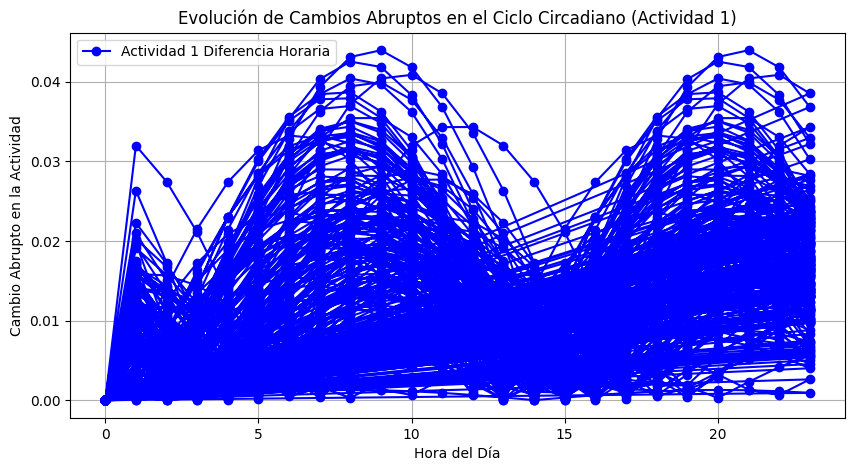

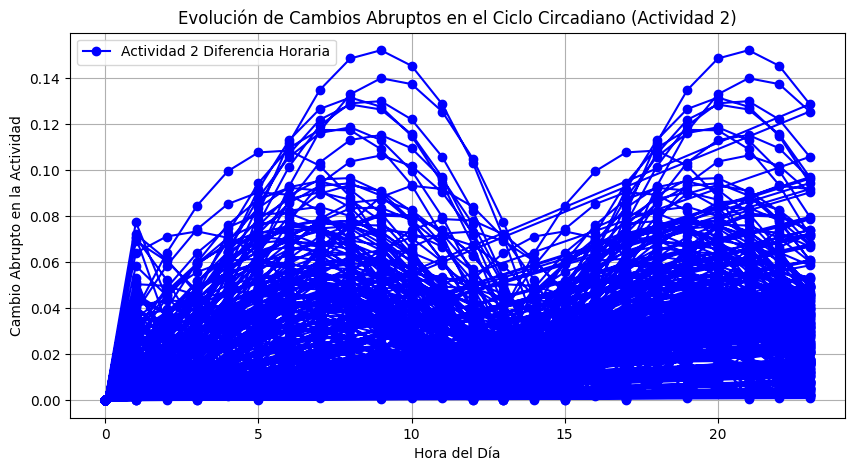

,Fecha,Hora,period eating,period other,period resting,period rumination,period eating_count,period other_count,period resting_count,period rumination_count,activity_level,activity_level_2,diferencia_x,distancia_acumulada_x,stress_level_1,diferencia_y,distancia_acumulada_y,stress_level_2
0,2024-01-01,0,0.079,0.0,0.410,0.511,1.0,0.0,4.0,2.0,-0.209528,-1.025107,0.000000,0.032615,normal,0.000000,0.163218,normal
1,2024-01-01,1,0.000,0.0,0.652,0.348,0.0,0.0,1.0,1.0,-0.327217,-0.443815,0.004730,0.043522,normal,0.000682,0.226450,normal
2,2024-01-01,2,0.000,0.0,0.443,0.557,0.0,0.0,1.0,1.0,-0.249102,-0.443815,0.002365,0.049252,normal,0.024080,0.266243,normal
3,2024-01-01,3,0.000,0.0,0.462,0.538,0.0,0.0,2.0,2.0,-0.256203,-0.887631,0.009300,0.051701,normal,0.045838,0.289440,normal
4,2024-01-01,4,0.000,0.0,0.711,0.289,0.0,0.0,1.0,1.0,-0.349269,-0.443815,0.015600,0.052217,normal,0.064471,0.300108,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3931,2024-06-30,19,1.000,0.0,0.000,0.000,1.0,0.0,0.0,0.0,0.261279,0.200319,0.003221,0.188949,normal,0.059360,0.132182,normal
3932,2024-06-30,20,0.341,0.0,0.000,0.659,1.0,0.0,0.0,1.0,0.034052,-0.074599,0.006818,0.193824,normal,0.058566,0.133548,normal
3933,2024-06-30,21,0.000,0.0,0.551,0.449,0.0,0.0,1.0,2.0,-0.289468,-0.718734,0.009950,0.201129,normal,0.053781,0.136490,normal
3934,2024-06-30,22,0.416,0.0,0.000,0.584,1.0,0.0,0.0,1.0,0.059913,-0.074599,0.012404,0.210050,normal,0.045331,0.141006,normal


In [12]:
import pandas as pd
import numpy as np
from scipy.fft import fft, ifft
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt

nombre_csv=1
df= pd.read_csv(f'Data1_actividad/{nombre_csv}.csv')
# Convertir 'Fecha' y 'Hora' a datetime
df['datetime'] = pd.to_datetime(df['Fecha'] + ' ' + df['Hora'].astype(str) + ':00:00')
df = df.set_index('datetime')
df = df.sort_index()

# Función para calcular el ciclo circadiano utilizando la Transformada de Fourier
def extract_circadian_cycle(data):
    fft_result = fft(data)
    n = len(data)
    freq = np.fft.fftfreq(n, d=1/24)
    
    # Filtrar para mantener solo frecuencias cercanas a 1 ciclo diario
    fft_filtered = fft_result.copy()
    fft_filtered[(freq < 0.8) | (freq > 1.2)] = 0
    
    # Reconstrucción de la señal para obtener el ciclo circadiano
    return np.real(ifft(fft_filtered))

# Función para calcular diferencias horarias en la actividad circadiana
def calculate_hourly_differences(cycle_data):
    return np.abs(np.diff(cycle_data, prepend=cycle_data[0]))

# Función para procesar una columna de actividad y analizar cambios abruptos
def process_activity_with_continuity(df, activity_column):
    daily_cycles = {}
    
    # Extraer el ciclo circadiano de cada día
    for date, group in df.groupby(df.index.date):
        if len(group) == 24:
            daily_cycles[date] = extract_circadian_cycle(group[activity_column].values)

    # Ciclo circadiano promedio
    average_cycle = np.mean(list(daily_cycles.values()), axis=0)

    # Análisis de diferencias horarias acumulativas para cambios abruptos
    abrupt_changes = []
    for date, cycle in daily_cycles.items():
        hourly_diffs = calculate_hourly_differences(cycle)
        abrupt_changes.extend([{
            'Fecha': date,
            'Hora': hour,
            'diferencia': hourly_diffs[hour],
            'distancia_acumulada': euclidean(average_cycle[:hour+1], cycle[:hour+1])
        } for hour in range(24)])

    abrupt_changes_df = pd.DataFrame(abrupt_changes)

    # Calcular umbrales dinámicos para las etiquetas de estrés
    min_diff = abrupt_changes_df['diferencia'].min()
    max_diff = abrupt_changes_df['diferencia'].max()
    threshold1 = min_diff + (max_diff - min_diff) / 2
    threshold2 = threshold1 + (max_diff - threshold1) / 2

    # Etiquetas de estrés por cada hora según diferencias abruptas
    def get_dynamic_stress_label(diff):
        if diff <= threshold1:
            return 'normal'
        elif diff <= threshold2:
            return 'alerta'
        else:
            return 'peligro'

    abrupt_changes_df['stress_level'] = abrupt_changes_df['diferencia'].apply(get_dynamic_stress_label)
    
    return abrupt_changes_df[['Fecha', 'Hora', 'diferencia', 'distancia_acumulada', 'stress_level']]

# Procesar las dos columnas de actividad y calcular niveles de estrés con continuidad temporal
stress_levels_1 = process_activity_with_continuity(df, 'activity_level').rename(columns={'stress_level': 'stress_level_1'})
stress_levels_2 = process_activity_with_continuity(df, 'activity_level_2').rename(columns={'stress_level': 'stress_level_2'})

# Fusionar niveles de estrés con el DataFrame original
df['Fecha'] = pd.to_datetime(df['Fecha'])
stress_levels_1['Fecha'] = pd.to_datetime(stress_levels_1['Fecha'])
stress_levels_2['Fecha'] = pd.to_datetime(stress_levels_2['Fecha'])
df['Hora'] = df['Hora'].astype(int)
stress_levels_1['Hora'] = stress_levels_1['Hora'].astype(int)
stress_levels_2['Hora'] = stress_levels_2['Hora'].astype(int)

# Fusionar todos los DataFrames en df_final
df_final = df.merge(stress_levels_1, on=['Fecha', 'Hora'], how='left')
df_final = df_final.merge(stress_levels_2, on=['Fecha', 'Hora'], how='left')

# Visualización de cambios abruptos en el ciclo circadiano
def plot_circadian_changes(abrupt_changes_df, activity_label):
    plt.figure(figsize=(10, 5))
    plt.plot(abrupt_changes_df['Hora'], abrupt_changes_df['diferencia'], marker='o', linestyle='-', color='b', label=f'{activity_label} Diferencia Horaria')
    plt.xlabel('Hora del Día')
    plt.ylabel('Cambio Abrupto en la Actividad')
    plt.title(f'Evolución de Cambios Abruptos en el Ciclo Circadiano ({activity_label})')
    plt.grid(True)
    plt.legend()
    plt.show()

# Visualizar los cambios abruptos en ambas actividades
plot_circadian_changes(stress_levels_1, 'Actividad 1')
plot_circadian_changes(stress_levels_2, 'Actividad 2')

# Resultado final
df_final


In [9]:
print(df_final['stress_level_1'].value_counts())

stress_level_1
normal     3221
alerta      603
peligro     112
Name: count, dtype: int64


In [10]:
print(df_final['stress_level_2'].value_counts())

stress_level_2
normal     3660
alerta      222
peligro      54
Name: count, dtype: int64


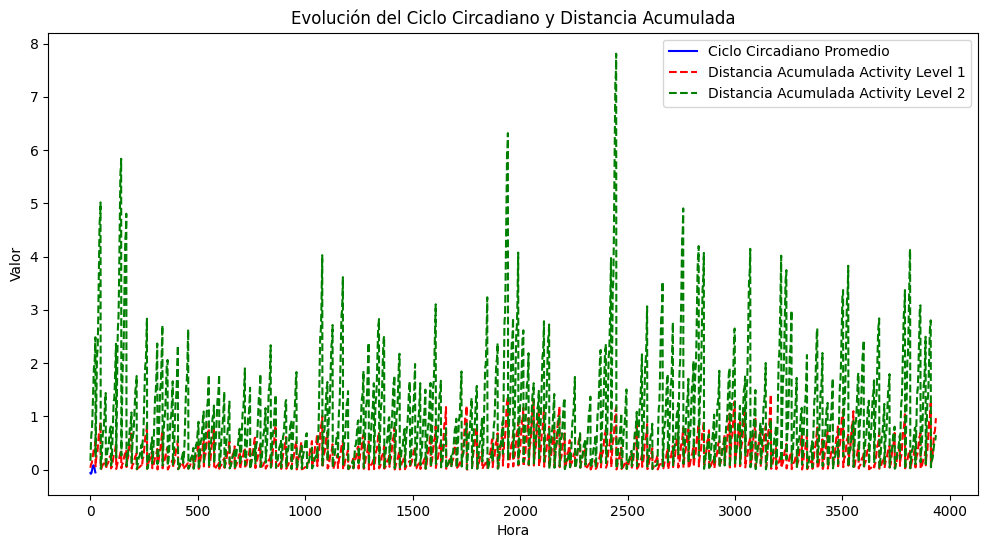

In [14]:
import pandas as pd
import numpy as np
from scipy.fft import fft, ifft
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt

nombre_csv=1
df= pd.read_csv(f'Data1_actividad/{nombre_csv}.csv')
# Convertir 'Fecha' y 'Hora' a datetime
df['datetime'] = pd.to_datetime(df['Fecha'] + ' ' + df['Hora'].astype(str) + ':00:00')
df = df.set_index('datetime')
df = df.sort_index()


# Función para calcular la Transformada de Fourier y extraer el ciclo circadiano
def extract_circadian_cycle(data):
    fft_result = fft(data)
    n = len(data)
    freq = np.fft.fftfreq(n, d=1/24)
    
    # Filtrar frecuencias cercanas a 1 ciclo por día
    fft_filtered = fft_result.copy()
    fft_filtered[(freq < 0.8) | (freq > 1.2)] = 0
    
    # Reconstruir la señal
    return np.real(ifft(fft_filtered))

# Función para calcular distancia acumulada y etiquetar niveles de estrés
def process_activity_with_accumulated_distance(df, activity_column):
    # Calcular el ciclo circadiano promedio
    daily_cycles = {}
    for date, group in df.groupby(df.index.date):
        if len(group) == 24:  # Asegurarse de que hay 24 horas de datos
            daily_cycles[date] = extract_circadian_cycle(group[activity_column].values)

    # Calcular el ciclo circadiano promedio
    average_cycle = np.mean(list(daily_cycles.values()), axis=0)

    # Calcular la distancia por hora y la distancia acumulada
    hourly_distances = []
    accumulated_distance = 0
    for date, cycle in daily_cycles.items():
        daily_accumulated_distances = []  # Almacenar la distancia acumulada por hora para cada día
        for hour in range(24):
            # Calcular la distancia euclidiana entre la hora actual y el ciclo promedio
            distance = abs(average_cycle[hour] - cycle[hour])
            accumulated_distance += distance  # Incrementar la distancia acumulada
            
            # Almacenar distancia por hora y distancia acumulada
            daily_accumulated_distances.append({
                'Fecha': date,
                'Hora': hour,
                'distancia': distance,
                'distancia_acumulada': accumulated_distance
            })
        
        hourly_distances.extend(daily_accumulated_distances)
        accumulated_distance = 0  # Reiniciar la distancia acumulada para el siguiente día

    # Convertir las distancias horarias a un DataFrame
    distance_df = pd.DataFrame(hourly_distances)

    # Calcular los umbrales para los niveles de estrés usando la distancia acumulada
    min_accumulated_distance = distance_df['distancia_acumulada'].min()
    max_accumulated_distance = distance_df['distancia_acumulada'].max()
    threshold1 = min_accumulated_distance + (max_accumulated_distance - min_accumulated_distance) / 3
    threshold2 = threshold1 + (max_accumulated_distance - threshold1) / 2

    # Función para determinar el nivel de estrés basado en la distancia acumulada
    def get_stress_level(accumulated_distance):
        if accumulated_distance <= threshold1:
            return 'normal'
        elif accumulated_distance <= threshold2:
            return 'alerta'
        else:
            return 'peligro'

    # Aplicar la función a las distancias acumuladas y crear una columna de niveles de estrés
    distance_df['stress_level'] = distance_df['distancia_acumulada'].apply(get_stress_level)
    
    return distance_df[['Fecha', 'Hora', 'distancia', 'distancia_acumulada', 'stress_level']]

# Procesar ambas columnas de actividad usando la distancia acumulada
stress_levels_1 = process_activity_with_accumulated_distance(df, 'activity_level')
stress_levels_2 = process_activity_with_accumulated_distance(df, 'activity_level_2')

# Renombrar las columnas para diferenciar los niveles de estrés
stress_levels_1 = stress_levels_1.rename(columns={'stress_level': 'stress_level_1'})
stress_levels_2 = stress_levels_2.rename(columns={'stress_level': 'stress_level_2'})

# Preparar los DataFrames para la fusión
df['Fecha'] = pd.to_datetime(df['Fecha'])
stress_levels_1['Fecha'] = pd.to_datetime(stress_levels_1['Fecha'])
stress_levels_2['Fecha'] = pd.to_datetime(stress_levels_2['Fecha'])
df['Hora'] = df['Hora'].astype(int)
stress_levels_1['Hora'] = stress_levels_1['Hora'].astype(int)
stress_levels_2['Hora'] = stress_levels_2['Hora'].astype(int)

# Combinar todos los DataFrames
df_final = df.merge(stress_levels_1, on=['Fecha', 'Hora'], how='left')
df_final = df_final.merge(stress_levels_2, on=['Fecha', 'Hora'], how='left')

# El resultado final está en df_final
df_final

# Generar gráfica del ciclo circadiano y de la distancia acumulada
plt.figure(figsize=(12, 6))
plt.plot(average_cycle, label="Ciclo Circadiano Promedio", color='blue')
plt.plot(stress_levels_1['distancia_acumulada'], label="Distancia Acumulada Activity Level 1", color='red', linestyle='--')
plt.plot(stress_levels_2['distancia_acumulada'], label="Distancia Acumulada Activity Level 2", color='green', linestyle='--')
plt.xlabel("Hora")
plt.ylabel("Valor")
plt.title("Evolución del Ciclo Circadiano y Distancia Acumulada")
plt.legend()
plt.show()
